In [1]:
import numpy as np # numerical library
import scipy as sp # scientific library (statistics, least-square solver, etc)
import pandas as pd # simplifies handling with datasets, handling is similar to matlab or R
import matplotlib as mpl # plot library
import matplotlib.pyplot as plt # plot commands
import seaborn as sns # helper library for more advanced charts

%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}

# Simplified simulation of wireless signal path loss

The path-loss shadowing model: $PL(d) = PL_0 + 10\gamma\log_{10}(\frac{d}{d_0}) + \mathcal{X}_g(0, \sigma^2)$

Next, we explain it to the reader. The path loss ($PL$) changes with euclidian distance between transmitter and receiver antenna ($d$), $PL_0$ is path loss at reference distance $d_0$, and $\mathcal{X}$ is random variable with some distribution. The distribution depends on environment. For the sake of simplicity we assume Gaussian distribution with mean equal to zero. At this point, we also assume that antennas are **isotropic**, which have no directivity ($D_t = D_r = 1$).

In [2]:
# Anonymous function for free space path loss (FSPL)
FSPL = lambda d, lambda0: 20 * np.log10(4*np.pi*d/lambda0)

# Traditional function
def log_distance_func(d, PL0, d0, gamma):
    """This function implements log-distance shadowing model"""
    assert gamma >= 2, f'gamma must be be equal or greater than 2, was {gamma}'

    return PL0 + 10*gamma*np.log10(d / d0)

Let's assume that we have the following dataset:

In [3]:
# We will pretend that we don't know constants below
d0 = 1.0
lambda0 = 3e8 / 2.45e9
gamma = 3.2
sigma = 4.1

d = np.linspace(1, 30, 200)


# Calculate path loss according to the log-distance model
loss = log_distance_func(d, FSPL(d, lambda0), d0, gamma)

# Make simulated data noisy
rng = np.random.default_rng(seed=0xDEADBEEF)
loss += rng.normal(0, sigma, size=d.shape)

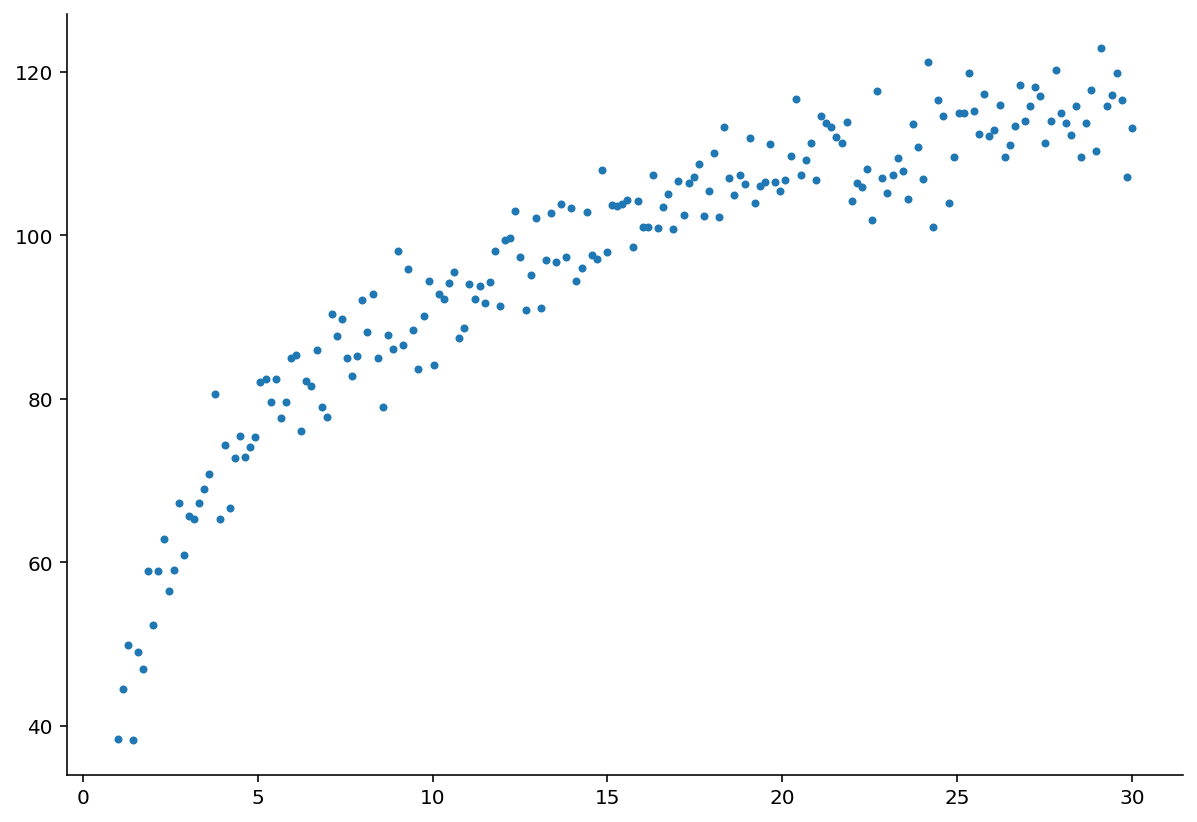

In [4]:
plt.figure(figsize=(10,7))
plt.scatter(d, loss, marker='.')
sns.despine()

Now let's pretend that we don't know model parameters and those are just measurements, which we got. We will try to find model parameters.

      fun: 3.996503671695071
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.44089210e-08, 7.10542736e-07, 4.88498131e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 96
      nit: 19
   status: 0
  success: True
        x: array([39.95410059,  1.00003803,  5.19547523])


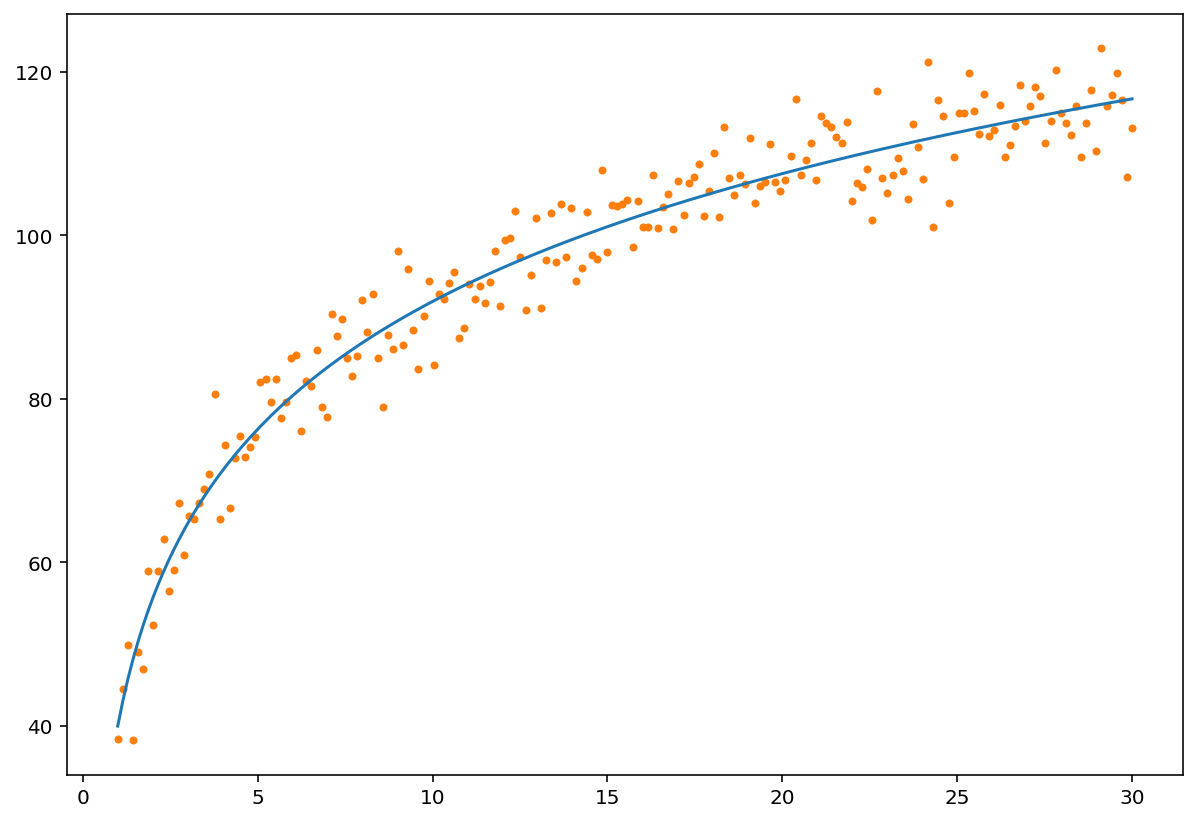

In [5]:
# Define loss "score" function: Root-Mean-Square-Error function
RMSE = lambda y_true, y_pred: np.sqrt(np.mean(np.square(y_true - y_pred)))


def objective_func(params, *args, **kwargs):
    PL0, d0, gamma = params
    d, y_true = args
    y_pred = log_distance_func(d, *params)
    
    return RMSE(y_true, y_pred)

out = sp.optimize.minimize(
    objective_func, # objective function
    x0=(0., 1., 2.), # initial values
    bounds=([0, None], [1, None], [2, None]), # minimization bounds (value ranges)
    args=(d, loss)
)

print(out)
plt.figure(figsize=(10,7))
plt.scatter(d, loss, c='C1', marker='.')
plt.plot(d, log_distance_func(d, *out.x), c='C0')